żródła: https://github.com/bchaber/1di2153
https://julialang.org/blog/2015/10/auto-diff-in-julia/
https://web.archive.org/web/20200615205643/http://blog.rogerluo.me/2018/10/23/write-an-ad-in-one-day/

#### Deklaracje

In [133]:
# definicja liczby dualnej
struct Dual{T <:Number} <:Number
     value::T
     derivative::T
end

# funkcje zwracające pochodną i wartość liczby dualnej
value(d::Dual) = d.value
derivative(d::Dual) = d.derivative


abstract type Node end
abstract type Operator end
abstract type LeafNode <: Node end

# zmienna używana w różniczkowaniu w tył - składa się z wartości i pochodnej
mutable struct Variable{T} <: LeafNode
    value::T
    grad::T
    Variable(val::T) where T          = new{T}(val, zero(val))
    Variable(val::T, grad::T) where T = new{T}(val, grad)
end

struct Method{OT} <: Operator
    f::OT
end

struct Broadcasted{OT} <: Operator
    f::OT
end

struct ComputableNode{OT <: Operator, AT <: Tuple, KT <: NamedTuple} <: Node
    op::OT
    args::AT
    kwargs::KT
end
ComputableNode(op::Function, args, kwargs) = ComputableNode(Method(op), args, kwargs)
ComputableNode(op, args)                   = ComputableNode(op, args, NamedTuple())

# węzeł przechowujący wartość wynikową oraz operację
mutable struct CachedNode{NT <: Node, OUT} <: Node
    node::NT
    out::OUT
end


# przeciążenie operatorów dla liczb dualnych
function Base.sqrt(x::Dual)
    new_value = sqrt(value(x))
    new_derivative = 0.5 / new_value
    return Dual(new_value, new_derivative*derivative(x))
end

function Base.:+(x::Dual, y::Dual)
    new_value = value(x) + value(y)
    new_derivative = derivative(x) + derivative(y)
    return Dual(new_value, new_derivative)
end

function Base.exp(x::Dual)
    new_value = exp(value(x))
    new_derivative = exp(value(x)*derivative(x))
    return Dual(new_value, new_derivative*derivative(x))
end

function Base.cos(x::Dual)
    new_value = cos(value(x))
    new_derivative = -sin(value(x))
    return Dual(new_value, new_derivative*derivative(x))
end


function Base.sin(x::Dual)
    new_value = sin(value(x))
    new_derivative = cos(value(x))
    return Dual(new_value, new_derivative*derivative(x))
end


function Base.:-(x::Dual, y::Dual)
    new_value = value(x) - value(y)
    new_derivative = derivative(x) - derivative(y)
    return Dual(new_value, new_derivative)
end

function Base.:*(x::Dual, y::Dual)
    val_x, val_y = value(x), value(y)
    new_value = val_x * val_y
    new_derivative = val_y * derivative(x) + val_x * derivative(y)
    return Dual(new_value, new_derivative)
end

function Base.:/(x::Dual, y::Dual)
    val_x, val_y = value(x), value(y)
    new_value = val_x / val_y
    new_derivative = (derivative(x) * val_y - val_x * derivative(y))/val_y^2
    return Dual(new_value, new_derivative)
end

function Base.:isless(x::Dual, y::Dual)
    return x.value < y.value
end

# przeciążenie operatorów dla węzłów w różniczkowaniu w tył
import Base: +, -, *, /
+(x::Node) = CachedNode(+, x)
-(x::Node) = CachedNode(-, x)
gradient(::typeof(+), grad, output, x) = (grad * 1, )
gradient(::typeof(-), grad, output, x) = (grad *-1, )
+(x::Node, y::Node) = CachedNode(+, x, y)
-(x::Node, y::Node) = CachedNode(-, x, y)
*(x::Node, y::Node) = CachedNode(*, x, y)
/(x::Node, y::Node) = CachedNode(/, x, y)
gradient(::typeof(+), grad, output, x, y) = (grad * one(x),   grad * one(y))
gradient(::typeof(-), grad, output, x, y) = (grad * one(x),   grad *-one(y))
gradient(::typeof(*), grad, output, x, y) = (grad * y,        grad * x)
gradient(::typeof(/), grad, output, x, y) = (grad * one(x)/y, grad *-x/y/y)

import Base: abs, sin, cos, tan, exp, sqrt, zero, isless
abs(x::Node)  = CachedNode(abs, x)
abs(x::Dual) = Dual(abs(x.value), sign(x.value)*x.derivative)
sin(x::Node)  = CachedNode(sin, x)
cos(x::Node)  = CachedNode(cos, x)
tan(x::Node)  = CachedNode(tan, x)
exp(x::Node)  = CachedNode(exp, x)
sqrt(x::Node) = CachedNode(sqrt, x)
zero(x::Node) = CachedNode(zero, x)
isless(x::Node, y::Node) = isless(value(x), value(y))
gradient(::typeof(abs), grad, output, x)  = (grad * sign(x),)
gradient(::typeof(sin), grad, output, x)  = (grad * cos(x),)
gradient(::typeof(cos), grad, output, x)  = (grad *-sin(x),)
gradient(::typeof(tan), grad, output, x)  = (grad *(tan(x)^2 + 1),)
gradient(::typeof(exp), grad, output, x)  = (grad * exp(x),)
gradient(::typeof(sqrt), grad, output, x) = (grad * 0.5/sqrt(x),)
gradient(::typeof(zero), grad, output, x) = (0,)

#promocja i konwersja typów
import Base: convert, promote_rule
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.value), convert(T, x.derivative))
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}
convert(::Type{Variable{T}}, x::Number) where T   = Variable(convert(T, x))
convert(::Type{Variable{T}}, x::Variable) where T = Variable(convert(T, x.value), convert(T, x.grad))
promote_rule(::Type{Variable{T}}, ::Type{R}) where {T,R} = Variable{promote_type(R,T)}



function CachedNode(op, args...; kwargs...)
    node = ComputableNode(op, args, kwargs.data)
    out  = forward(node)
    CachedNode(node, out)
end

arg(x::ComputableNode, i::Int) = x.args[i]
args(x::ComputableNode) = x.args
kwargs(x::ComputableNode) = x.kwargs
operator(x::ComputableNode) = x.f

arg(x::CachedNode, i::Int) = x.node.args[i]
args(x::CachedNode) = x.node.args
kwargs(x::CachedNode) = x.node.kwargs
operator(x::CachedNode) = x.node.f

forward(x) = x
forward(leaf::LeafNode) = value(leaf)
forward(node::ComputableNode) = forward(node.op, map(forward, node.args)...; map(forward, node.kwargs)...)
forward(cached::CachedNode) = (cached.out = forward(cached.node))
forward(op::Broadcasted, args...) = Broadcast.broadcasted(op.f, args...)
forward(op::Operator, args...; kwargs...) = op.f(args...; kwargs...)


value(x) = x
value(x::Variable) = x.value
value(x::CachedNode) = value(x.out)

function backward(x::Variable, grad)
    if isdefined(x, :grad)
        x.grad+= grad
    else
        x.grad = grad
    end
    nothing
end

function backward(node::CachedNode, f, grad)
    grad_inputs = gradient(node, grad)
    for (each, each_grad) in zip(args(node), grad_inputs)
        backward(each, each_grad)
    end
    nothing
end

function backward(cached::CachedNode, op::Broadcasted, grad)
    grad_inputs = gradient(cached, grad)
    for (each, each_grad) in zip(args(cached), grad_inputs)
        backward(each, each_grad)
    end
    nothing
end

backward(cached::CachedNode) = backward(cached, 1.0)
backward(cached::CachedNode, grad) = backward(cached, cached.node.op, grad)
backward(cached::CachedNode, op::Method, grad) = backward(cached, op.f, grad)
backward(cached::CachedNode, ::typeof(Broadcast.materialize), grad) = backward(arg(cached, 1), grad)
gradient(x::CachedNode, grad) = gradient(x.node.op, grad, x.out, map(value, x.node.args)...; map(value, x.node.kwargs)...)
gradient(x::Operator,   grad, out, args...; kwargs...) = gradient(x.f, grad, out, args...; kwargs...)



struct ComputGraphStyle <: Broadcast.BroadcastStyle end
Base.BroadcastStyle(::Type{<:Node}) = ComputGraphStyle()
Broadcast.BroadcastStyle(s::ComputGraphStyle, x::Broadcast.BroadcastStyle) = s
Broadcast.broadcasted(::ComputGraphStyle, f, args...) = CachedNode(Broadcasted(f), args...)
Broadcast.broadcastable(x::Node) = x
Broadcast.materialize(x::Node) = CachedNode(Broadcast.materialize, x)
Base.similar(x::Node)                                      = Variable(similar(value(x)))
Base.similar(x::Node, dims::Dims)                          = Variable(similar(value(x), dims))
Base.similar(x::Node, eltype::Type{S}, dims::Dims) where S = Variable(similar(value(x), eltype, dims))

gradient(::Broadcasted{typeof(+)}, grad, output, x)    = @. (grad * 1, )
gradient(::Broadcasted{typeof(-)}, grad, output, x)    = @. (grad *-1, )
gradient(::Broadcasted{typeof(+)}, grad, output, x, y) = @. (grad * one(x),   grad * one(y))
gradient(::Broadcasted{typeof(-)}, grad, output, x, y) = @. (grad * one(x),   grad *-one(y))
gradient(::Broadcasted{typeof(*)}, grad, output, x, y) = @. (grad * y,        grad * x)
gradient(::Broadcasted{typeof(/)}, grad, output, x, y) = @. (grad * one(x)/y, grad *-x/y/y)
gradient(::Broadcasted{typeof(abs)}, grad, output, x)  = @. (grad * sign(x), )
gradient(::Broadcasted{typeof(sin)}, grad, output, x)  = @. (grad *  cos(x),  )
gradient(::Broadcasted{typeof(cos)}, grad, output, x)  = @. (grad * -sin(x), )
gradient(::Broadcasted{typeof(tan)}, grad, output, x)  = @. (grad * (tan(x)^2 + 1), )
gradient(::Broadcasted{typeof(exp)}, grad, output, x)  = @. (grad *  exp(x), )
gradient(::Broadcasted{typeof(sqrt)}, grad, output, x) = @. (grad *.5/sqrt(x), )

function reverse_derivative(f,x)
    var = Variable(x)
    backward(f(var))
    return var.grad
end

function forward_derivative(f,x)
    return derivative(f(Dual(x,1.0)))
end

forward_derivative (generic function with 1 method)

### Działanie rózniczkowania

In [179]:
## testowe funkcje sinus i ReLU
foo(x) = sin(x)
ReLU(x) = x > zero(x) ? abs(x) : zero(x)
v = -5:.1:5;
v1 = -1:.1:1;

#metoda rózniczkowania numerycznego centralnego
center_diff(f, x₀; Δx=1e-5) = ( f(x₀ + Δx) - f(x₀ - Δx) )/2Δx

center_diff (generic function with 1 method)

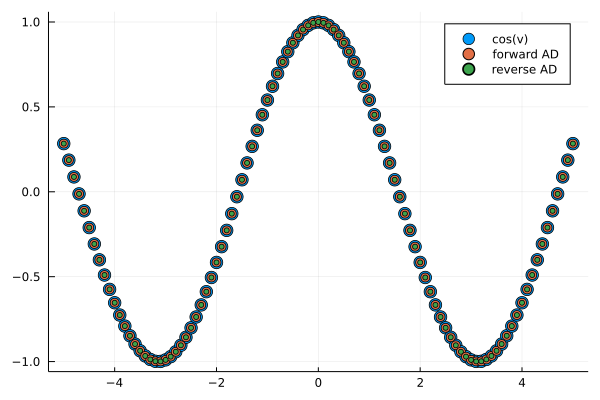

In [180]:
using Plots
plot(v, cos.(v),line=nothing, marker=:circle, markersize=7., label="cos(v)")
plot!(v, forward_derivative.(foo,v),line=nothing, marker=:circle, markersize=5., label="forward AD")
plot!(v, reverse_derivative.(foo,v), line=nothing, marker=:circle, markersize=3., label="reverse AD")

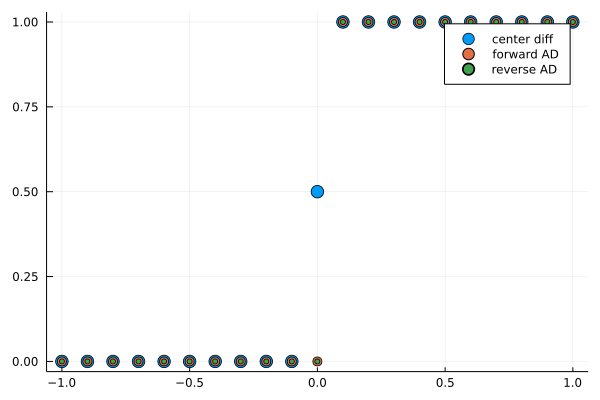

In [182]:
plot(v1,center_diff.(ReLU,v1),line=nothing, marker=:circle, markersize=7., label="center diff")
plot!(v1, forward_derivative.(ReLU,v1),line=nothing, marker=:circle, markersize=5., label="forward AD")
plot!(v1, reverse_derivative.(ReLU,v1), line=nothing, marker=:circle, markersize=3., label="reverse AD")

### Jacobian

In [172]:
# Funkcja wykoniania Jacobianu przy użyciu różniczkowania w przód
J_forward = function jacobian_forward(f, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
    
    for i=1:length(args)
        x = Dual{T}[]
        for j=1:length(args)
            if(i == j)
                push!(x, Dual(args[j], one(args[j])))
            else
                push!(x, Dual(args[j],zero(args[j])) )
            end
        end
        column = derivative.([f(x)...])
        push!(jacobian_columns, column[:,:])
    end
    hcat(jacobian_columns...)
end

# Inne podejście do Jacobiana dla różniczkowania w przód
J1 = function jacobian1(f, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
     ϵ = Dual(0., 1.)
    for i=1:length(args)
        x = Number[]
        dual_val = args[i] + ϵ
        for j = 1 : length(args)
            if(i == j)
                push!(x, dual_val)
            else
                push!(x, args[j])
            end      
        end
        column = derivative.(f(x))
        push!(jacobian_columns, column[:,:])   
    end
    hcat(jacobian_columns...)
end

# Funkcja Jacobianu dla różniczkowania w tył
J_reverse = function jacobian_reverse(f::Vector, args::Vector{T}) where {T <:Number} 
    jacobian_rows = Matrix{T}[]
    jacobian = Matrix{T}[]
    for i=1:length(f)
        variables =[]
        grad = Float64[]
        for j=1:length(args)
            var = Variable(args[j])
            push!(variables, var)
        end
        backward(f[i](variables))
        for j=1:length(variables)
            x = variables[j]
            push!(grad,x.grad)
        end
        push!(jacobian_rows, grad[:,:])
    end
    jacobian = hcat(jacobian_rows...)
    transpose(jacobian)
end


# Funkcja testowa przyjmująca wektor n-elementowy, wykonująca operacje matematyczne dla każdego elementu wektora
# i zwracająca pojedynczy wynik
function jacobianTestFunction(x::Vector)
    first_equation = x[1]
   # second_equation = 1
   # third_equation = 1
    for i = 1 : length(x)
        first_equation *= exp(sin(x[i]*x[i]))
    #    second_equation *= exp(sin(x[i]))
    #    third_equation *= sqrt(x[i]*cos(x[i]))
    end
    return first_equation
end

# Funkcja testowa przyjmująca wektor i zwracająca 100 wyników operacji exp(sin(x^2)/x^2) dla pierwszego elementu wektora
# W celach testowych przyjmujemy, że wektor jest jednoelementowy. W ten sposób otrzymujemy 1000 wyjść dla pojedynczego wejścia
function jacobianTestFunction1(x::Vector)
    output = Number[]
    for i=1:100
        push!(output, exp(sin(x[1]*x[1])/x[1]*x[1]))
    end
    return output
end

# Funckja analogiczna do funkcji testowej jacobianTestFunction1, dla metody różniczkowania w tył, zwaracjąca wwektor stu
# funkcji dla jedno elementowego wektora argumentu
function jacobianTestReverseFunction1()
    f_list = []
    for i=1:100
        f(x::Vector) = exp(sin(x[1]*x[1])/x[1]*x[1])
        push!(f_list, f)
    end
    return f_list
end

jacobianTestReverseFunction1 (generic function with 1 method)

#### Działanie funkcji Jacobianu 

In [173]:
## Funkcja dla której liczony będzie jakobian (rozniczkowanie w przód)
f(x::Vector) = [sin(x[1] - (sin(x[2])+x[3])), exp(x[1])+(x[2])*(x[1]) + (x[3])]

f (generic function with 1 method)

In [174]:
## Zadeklarowanie wektora dwóch funkcji takich samych jak powyżej, która wchodzi jako argument funkcji Jacobiana dla
# rózniczkowania w tył
f_1(x::Vector) = sin(x[1] - (sin(x[2])+x[3]))
f_2(x::Vector) = exp(x[1])+(x[2])*(x[1]) + (x[3])
f_list = [f_1, f_2]

2-element Vector{Function}:
 f_1 (generic function with 1 method)
 f_2 (generic function with 1 method)

###### Dla różniczkowania w przód

In [175]:
J_forward(f, [3.0,5.0,3.67])

2×3 Matrix{Float64}:
  0.958551  -0.271905  -0.958551
 25.0855     3.0        1.0

###### Dla różniczkowania w przód druga możliwość

In [176]:
J1(f, [3.0,5.0,3.67])

2×3 Matrix{Float64}:
  0.958551  -0.271905  -0.958551
 25.0855     3.0        1.0

###### Dla rózniczkowania w tył

In [51]:
J_reverse(f_list, [3.0,5.0,3.67])

2×3 transpose(::Matrix{Float64}) with eltype Float64:
  0.958551  -0.271905  -0.958551
 25.0855     3.0        1.0

#### Jacobian jednej funkcji wielu zmiennych

### Benchmarki funkcji Jacobianu

In [171]:
using BenchmarkTools

# Deklaracja 50-elementowego wektora zmiennych losowych, do przeprowadzania testów
x = rand(Float64,50);

###### Prównanie dwóch podejść tworzenia Jacobianu dla różniczkowania w przód

In [177]:
@benchmark J_forward(f, [3.0,5.0,3.67])

BenchmarkTools.Trial: 
  memory estimate:  2.48 KiB
  allocs estimate:  39
  --------------
  minimum time:     6.480 μs (0.00% GC)
  median time:      7.040 μs (0.00% GC)
  mean time:        7.948 μs (5.73% GC)
  maximum time:     2.386 ms (99.28% GC)
  --------------
  samples:          10000
  evals/sample:     5

In [178]:
@benchmark J1(f, [3.0,5.0,3.67])

BenchmarkTools.Trial: 
  memory estimate:  2.67 KiB
  allocs estimate:  63
  --------------
  minimum time:     11.100 μs (0.00% GC)
  median time:      12.400 μs (0.00% GC)
  mean time:        13.273 μs (0.00% GC)
  maximum time:     221.400 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

###### Porównanie funkcji Jacobianu dla różniczkowania w przód i tył

Dla jednej funkcji wielu zmiennych:

In [9]:
@benchmark J_forward(jacobianTestFunction, x)

BenchmarkTools.Trial: 
  memory estimate:  124.38 KiB
  allocs estimate:  459
  --------------
  minimum time:     215.400 μs (0.00% GC)
  median time:      218.400 μs (0.00% GC)
  mean time:        236.477 μs (2.88% GC)
  maximum time:     4.176 ms (89.41% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [10]:
@benchmark J_reverse([jacobianTestFunction], x)

BenchmarkTools.Trial: 
  memory estimate:  19.94 KiB
  allocs estimate:  718
  --------------
  minimum time:     141.200 μs (0.00% GC)
  median time:      145.200 μs (0.00% GC)
  mean time:        167.766 μs (1.13% GC)
  maximum time:     35.347 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

Dla wielu funkcji jednej zmiennej:

In [11]:
@benchmark J_forward(jacobianTestFunction1, [0.323])

BenchmarkTools.Trial: 
  memory estimate:  10.17 KiB
  allocs estimate:  120
  --------------
  minimum time:     14.900 μs (0.00% GC)
  median time:      15.900 μs (0.00% GC)
  mean time:        23.320 μs (3.66% GC)
  maximum time:     4.991 ms (99.24% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [17]:
@benchmark J_reverse(jacobianTestReverseFunction1(), [0.323])

BenchmarkTools.Trial: 
  memory estimate:  88.31 KiB
  allocs estimate:  2520
  --------------
  minimum time:     191.000 μs (0.00% GC)
  median time:      195.700 μs (0.00% GC)
  mean time:        218.085 μs (6.34% GC)
  maximum time:     11.707 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1